In [4]:
import matplotlib.pylab as plt

%matplotlib inline
import numpy as np
import os
import scipy

from osgeo import gdal
from sklearn import metrics

from skimage import exposure
from skimage import segmentation
from matplotlib import colors

import scipy.stats as ss

In [5]:
def plti(im, h=8, **kwargs):
    """
    Helper function to plot an image.
    """
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')

In [6]:
def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [7]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

In [8]:
raster2017_data_path = "data/qb20170003_0004.tif"
raster_dataset2017 = gdal.Open(raster2017_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset2017.GetGeoTransform()
proj = raster_dataset2017.GetProjectionRef()
image2017 = raster_dataset2017.GetRasterBand(1).ReadAsArray();

In [9]:
raster2015_data_path = "data/qb20150003_0004.tif"
raster_dataset2015 = gdal.Open(raster2015_data_path, gdal.GA_ReadOnly)
image2015 = raster_dataset2015.GetRasterBand(1).ReadAsArray();

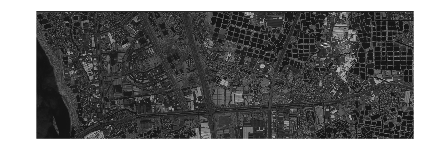

In [10]:
plti(image2017,20,cmap='gray')

568


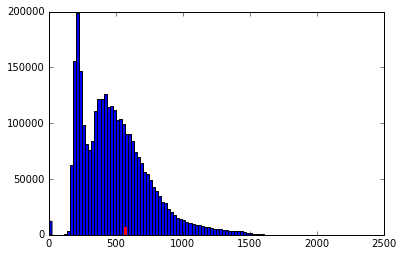

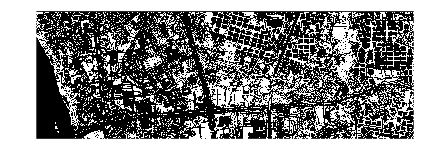

In [11]:
from skimage import filters

thresh = filters.threshold_otsu(image2017)
print(thresh)

thresholded = image2017 > thresh

plt.figure()
plt.hist(image2017.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');

plti(thresholded, 20,cmap='gray')

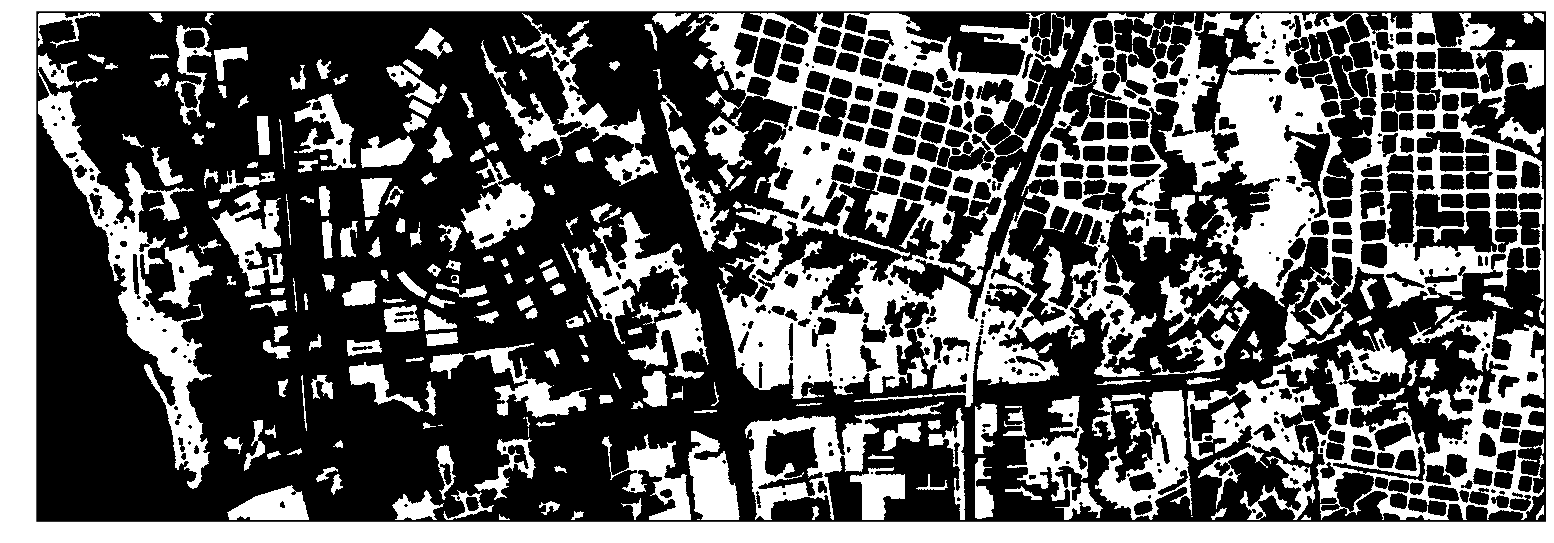

In [12]:
from skimage import morphology
from skimage.morphology import disk

no_small = morphology.remove_small_objects(thresholded, min_size=150)

thresholded_clean = morphology.binary_closing(no_small,disk(3)) 
plti(thresholded_clean, 80,cmap='gray')

In [13]:
training_data_path = "processedData/markedRaster.tif"
training_data = gdal.Open(training_data_path, gdal.GA_ReadOnly)
labeled_pixels = training_data.GetRasterBand(1).ReadAsArray();

2
[1 2]
(1022, 3022)


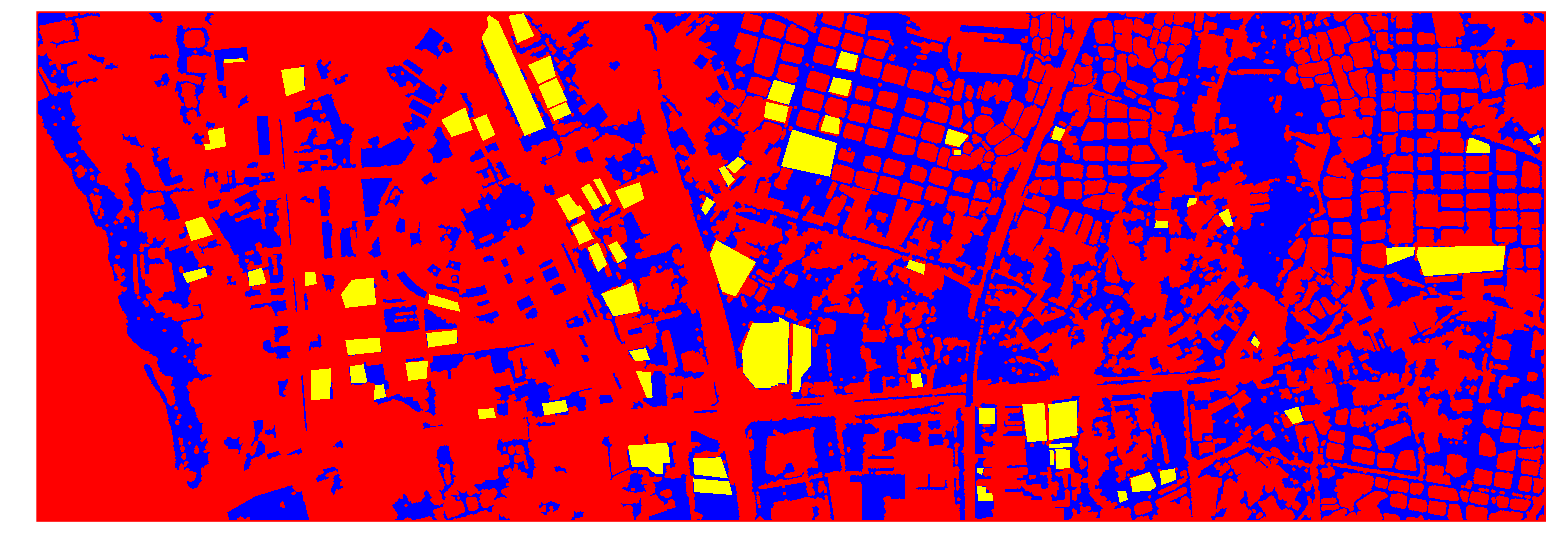

In [14]:
thresholded_clean [labeled_pixels == 1] = True
labeled_data = labeled_pixels + 1
labeled_data [thresholded_clean == False] = 0
ground_truth = labeled_data
classes = np.unique(ground_truth)[1:]  # 0 doesn't count, 1 same, 2 new building
print(len(classes))
print( classes)
print(ground_truth.shape)
from skimage import color
test_rgb = color.label2rgb(labeled_data)
plti(test_rgb, 80,cmap='jet')

In [15]:
from scipy import ndimage as ndi
from matplotlib.colors import ListedColormap

distance_im = ndi.distance_transform_edt(thresholded_clean)
print ('distance transform:', distance_im.shape, distance_im.dtype)

distance transform: (1022, 3022) float64


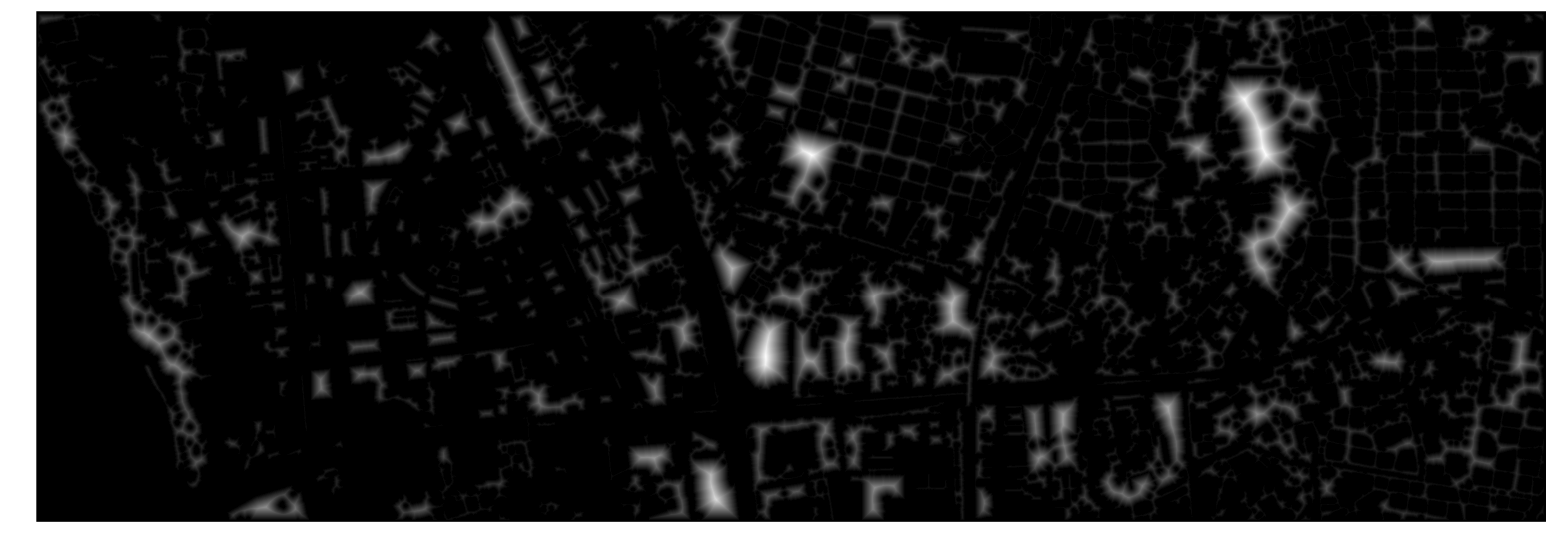

In [16]:
plti(distance_im, 80,cmap='gray')

In [17]:
from skimage import feature, measure
peaks_im = feature.peak_local_max(distance_im, indices=False)
print(len(peaks_im[peaks_im==True]))

26719


In [18]:
markers_im = measure.label(peaks_im)
print(markers_im.shape)
segments = morphology.watershed(-distance_im, markers_im, mask=thresholded_clean) 
print(segments.shape)
num_data = len(np.unique(segments))-1  # subtract 1 b/c background is labelled 0
print ('number of segments: %i' % num_data)

(1022, 3022)
(1022, 3022)
number of segments: 13114


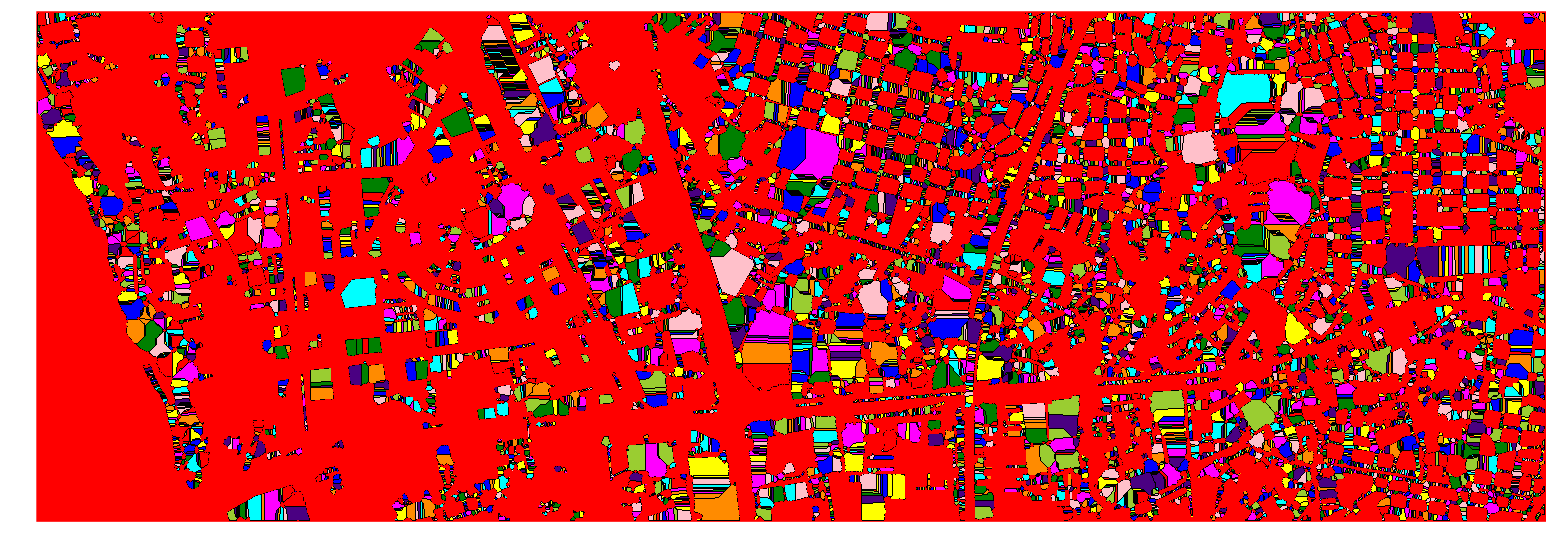

In [19]:
 from skimage import color
label_rgb = color.label2rgb(segments)
label_rgb2 = segmentation.mark_boundaries(label_rgb, segments, (0, 0, 0))
plti(label_rgb2, 80)

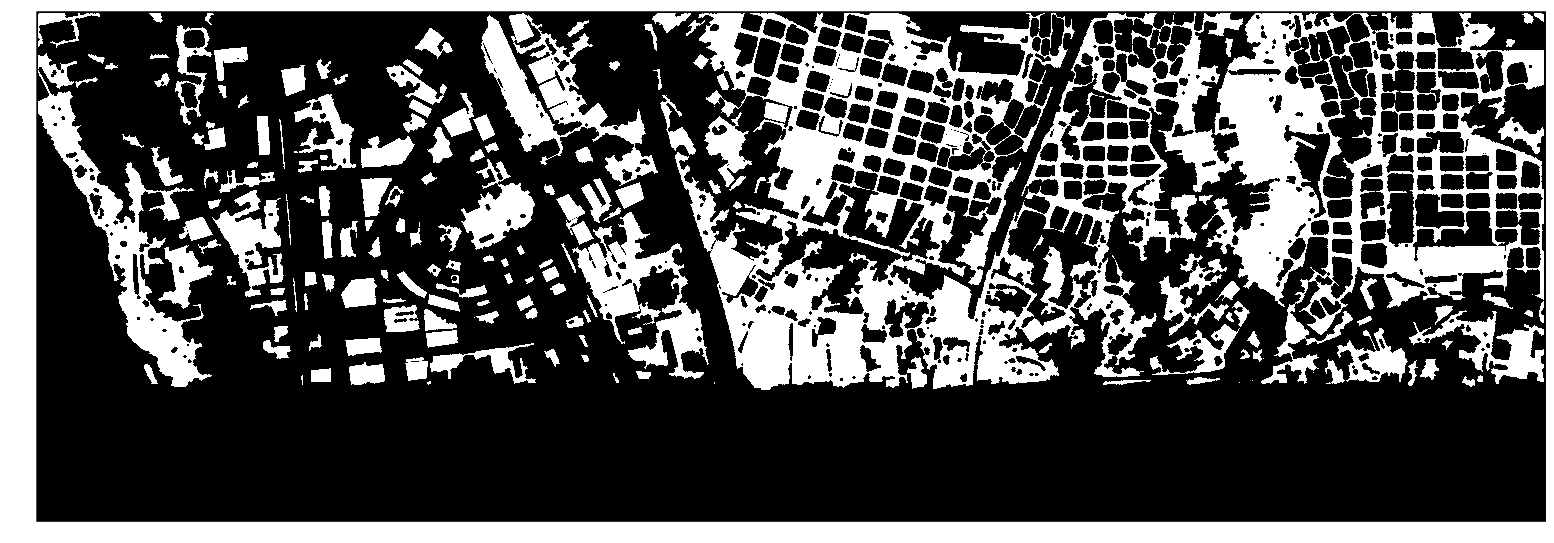

In [20]:
img_test = np.copy(thresholded_clean)
img_test[segments > 10000 ] = 0
plti(img_test, 80,cmap='gray')

In [21]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 12917
Training segments for class 2: 497


In [22]:
bands_data = []
bands_data.append(image2017)
bands_data.append(image2015)
bands_data = np.dstack(bands_data)

In [23]:
print(bands_data.shape)

(1022, 3022, 2)


In [24]:
segment_ids = np.unique(segments)
print(segment_ids)

[    0     1     2 ..., 13112 13113 13114]


In [47]:
feature_names = [
    'min1',
    'max1',
    'mean1',
    'var1',
    'skew1',
    'kurt1',
    'min2',
    'max2',
    'mean2',
    'var2',
    'skew2',
    'kurt2']

In [181]:
# create training data 
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_labels = []
    for klass in classes:
        for segment_label in segments_per_klass[klass]:
            segment_pixels = bands_data[segments==segment_label]
            segment_model = segment_features(segment_pixels)
            objects.append(segment_model)
            objects_labels.append(klass-1)  

    print("Created %i objects" % len(objects))

Created 13414 objects


In [182]:
objects[1]

[623, 1110, 866.5, 118584.5, 0.0, -2.0, 433, 458, 445.5, 312.5, 0.0, -2.0]

In [183]:
objects_labels[1]

0

In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(objects, objects_labels, test_size=0.33, random_state=42)

In [198]:
import tensorflow as tf

from tensorflow.contrib.data import Dataset, Iterator

In [199]:
train_imgs = tf.constant(X_train)
train_labels = tf.constant(y_train)
dataset = Dataset.from_tensor_slices((train_imgs, train_labels))
print(dataset.output_types)
print(dataset.output_shapes)

(tf.float32, tf.int32)
(TensorShape([Dimension(12)]), TensorShape([]))


In [200]:
# Create the feature_columns, which specifies the input to our model.
# All our input features are numeric, so use numeric_column for each one.
feature_columns = [tf.feature_column.numeric_column(k) for k in feature_names]

In [201]:
def my_input_fn(objects, objects_labels, perform_shuffle=False, repeat_count=1):
    def decode(x, y):
        return dict(zip(feature_names, tf.unstack(x))), y # Then build a dict from them
    
    train_imgs = tf.constant(objects)
    train_labels = tf.constant(objects_labels)
    dataset = Dataset.from_tensor_slices((train_imgs, train_labels))
    dataset = dataset.map(decode)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count) # Repeats dataset this # times
    dataset = dataset.batch(32)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

In [202]:
next_batch = my_input_fn(X_train[0:1], y_train[0:1], True) # Will return 32 random elements

# Now let's try it out, retrieving and printing one batch of data.
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
print(first_batch)

({'kurt1': array([-0.56054258], dtype=float32), 'kurt2': array([-1.14383638], dtype=float32), 'max2': array([ 509.], dtype=float32), 'max1': array([ 875.], dtype=float32), 'min1': array([ 538.], dtype=float32), 'skew2': array([ 0.33585364], dtype=float32), 'mean1': array([ 685.74468994], dtype=float32), 'mean2': array([ 444.56384277], dtype=float32), 'skew1': array([ 0.26222923], dtype=float32), 'var2': array([ 1289.49584961], dtype=float32), 'var1': array([ 5767.00927734], dtype=float32), 'min2': array([ 376.], dtype=float32)}, array([0], dtype=int32))


In [203]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
PATH = "{}/run-{}/".format(root_logdir, now)
feature_columns = [tf.feature_column.numeric_column(k) for k in feature_names]
# Create a deep neural network regression classifier.
# Use the DNNClassifier pre-made estimator
classifier = tf.estimator.DNNClassifier(
   feature_columns=feature_columns, # The input features to our model
   hidden_units=[10,20,10], # Two layers, each with 10 neurons
   n_classes=2,
   model_dir=PATH) # Path to where checkpoints etc are stored

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_tf_random_seed': 1, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': 'tf_logs/run-20171014132634/', '_save_summary_steps': 100}


INFO:tensorflow:Using config: {'_tf_random_seed': 1, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': 'tf_logs/run-20171014132634/', '_save_summary_steps': 100}


In [204]:
# Train our model, use the previously function my_input_fn
# Input to training is a file with training example
# Stop training after 8 iterations of train data (epochs)
classifier.train(
   input_fn=lambda: my_input_fn(X_train, y_train, True, 8))

INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into tf_logs/run-20171014132634/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into tf_logs/run-20171014132634/model.ckpt.


INFO:tensorflow:loss = 9518.95, step = 1


INFO:tensorflow:loss = 9518.95, step = 1


INFO:tensorflow:global_step/sec: 533.273


INFO:tensorflow:global_step/sec: 533.273


INFO:tensorflow:loss = 5.37537e-12, step = 101 (0.185 sec)


INFO:tensorflow:loss = 5.37537e-12, step = 101 (0.185 sec)


INFO:tensorflow:global_step/sec: 610.841


INFO:tensorflow:global_step/sec: 610.841


INFO:tensorflow:loss = 0.608174, step = 201 (0.164 sec)


INFO:tensorflow:loss = 0.608174, step = 201 (0.164 sec)


INFO:tensorflow:global_step/sec: 612.463


INFO:tensorflow:global_step/sec: 612.463


INFO:tensorflow:loss = 83.3959, step = 301 (0.163 sec)


INFO:tensorflow:loss = 83.3959, step = 301 (0.163 sec)


INFO:tensorflow:global_step/sec: 607.378


INFO:tensorflow:global_step/sec: 607.378


INFO:tensorflow:loss = 82.3867, step = 401 (0.165 sec)


INFO:tensorflow:loss = 82.3867, step = 401 (0.165 sec)


INFO:tensorflow:global_step/sec: 578.046


INFO:tensorflow:global_step/sec: 578.046


INFO:tensorflow:loss = 12.2098, step = 501 (0.173 sec)


INFO:tensorflow:loss = 12.2098, step = 501 (0.173 sec)


INFO:tensorflow:global_step/sec: 601.003


INFO:tensorflow:global_step/sec: 601.003


INFO:tensorflow:loss = 74.7479, step = 601 (0.166 sec)


INFO:tensorflow:loss = 74.7479, step = 601 (0.166 sec)


INFO:tensorflow:global_step/sec: 572.709


INFO:tensorflow:global_step/sec: 572.709


INFO:tensorflow:loss = 0.0377337, step = 701 (0.175 sec)


INFO:tensorflow:loss = 0.0377337, step = 701 (0.175 sec)


INFO:tensorflow:global_step/sec: 583.286


INFO:tensorflow:global_step/sec: 583.286


INFO:tensorflow:loss = 24.6062, step = 801 (0.171 sec)


INFO:tensorflow:loss = 24.6062, step = 801 (0.171 sec)


INFO:tensorflow:global_step/sec: 597.672


INFO:tensorflow:global_step/sec: 597.672


INFO:tensorflow:loss = 0.05747, step = 901 (0.167 sec)


INFO:tensorflow:loss = 0.05747, step = 901 (0.167 sec)


INFO:tensorflow:global_step/sec: 586.311


INFO:tensorflow:global_step/sec: 586.311


INFO:tensorflow:loss = 0.147453, step = 1001 (0.171 sec)


INFO:tensorflow:loss = 0.147453, step = 1001 (0.171 sec)


INFO:tensorflow:global_step/sec: 608.7


INFO:tensorflow:global_step/sec: 608.7


INFO:tensorflow:loss = 0.0407655, step = 1101 (0.164 sec)


INFO:tensorflow:loss = 0.0407655, step = 1101 (0.164 sec)


INFO:tensorflow:global_step/sec: 605.684


INFO:tensorflow:global_step/sec: 605.684


INFO:tensorflow:loss = 16.5189, step = 1201 (0.165 sec)


INFO:tensorflow:loss = 16.5189, step = 1201 (0.165 sec)


INFO:tensorflow:global_step/sec: 548.11


INFO:tensorflow:global_step/sec: 548.11


INFO:tensorflow:loss = 0.306548, step = 1301 (0.182 sec)


INFO:tensorflow:loss = 0.306548, step = 1301 (0.182 sec)


INFO:tensorflow:global_step/sec: 603.625


INFO:tensorflow:global_step/sec: 603.625


INFO:tensorflow:loss = 0.0611848, step = 1401 (0.166 sec)


INFO:tensorflow:loss = 0.0611848, step = 1401 (0.166 sec)


INFO:tensorflow:global_step/sec: 532.772


INFO:tensorflow:global_step/sec: 532.772


INFO:tensorflow:loss = 0.189876, step = 1501 (0.188 sec)


INFO:tensorflow:loss = 0.189876, step = 1501 (0.188 sec)


INFO:tensorflow:global_step/sec: 436.257


INFO:tensorflow:global_step/sec: 436.257


INFO:tensorflow:loss = 1.30627, step = 1601 (0.232 sec)


INFO:tensorflow:loss = 1.30627, step = 1601 (0.232 sec)


INFO:tensorflow:global_step/sec: 510.522


INFO:tensorflow:global_step/sec: 510.522


INFO:tensorflow:loss = 8.04765, step = 1701 (0.193 sec)


INFO:tensorflow:loss = 8.04765, step = 1701 (0.193 sec)


INFO:tensorflow:global_step/sec: 544.754


INFO:tensorflow:global_step/sec: 544.754


INFO:tensorflow:loss = 15.2651, step = 1801 (0.186 sec)


INFO:tensorflow:loss = 15.2651, step = 1801 (0.186 sec)


INFO:tensorflow:global_step/sec: 491.418


INFO:tensorflow:global_step/sec: 491.418


INFO:tensorflow:loss = 12.7802, step = 1901 (0.202 sec)


INFO:tensorflow:loss = 12.7802, step = 1901 (0.202 sec)


INFO:tensorflow:global_step/sec: 566.853


INFO:tensorflow:global_step/sec: 566.853


INFO:tensorflow:loss = 2.56424, step = 2001 (0.176 sec)


INFO:tensorflow:loss = 2.56424, step = 2001 (0.176 sec)


INFO:tensorflow:global_step/sec: 610.965


INFO:tensorflow:global_step/sec: 610.965


INFO:tensorflow:loss = 8.52382, step = 2101 (0.164 sec)


INFO:tensorflow:loss = 8.52382, step = 2101 (0.164 sec)


INFO:tensorflow:global_step/sec: 598.642


INFO:tensorflow:global_step/sec: 598.642


INFO:tensorflow:loss = 28.323, step = 2201 (0.167 sec)


INFO:tensorflow:loss = 28.323, step = 2201 (0.167 sec)


INFO:tensorflow:Saving checkpoints for 2247 into tf_logs/run-20171014132634/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2247 into tf_logs/run-20171014132634/model.ckpt.


INFO:tensorflow:Loss for final step: 10.4171.


INFO:tensorflow:Loss for final step: 10.4171.


In [205]:
# Evaluate our model using the examples contained in FILE_TEST
# Return value will contain evaluation_metrics such as: loss & average_loss
evaluate_result = classifier.evaluate(
    input_fn=lambda:  my_input_fn(X_test, y_test, False, 4))
print("Evaluation results")
for key in evaluate_result:
    print("   {}, was: {}".format(key, evaluate_result[key]))

INFO:tensorflow:Starting evaluation at 2017-10-14-13:26:44


INFO:tensorflow:Starting evaluation at 2017-10-14-13:26:44


INFO:tensorflow:Restoring parameters from tf_logs/run-20171014132634/model.ckpt-2247


INFO:tensorflow:Restoring parameters from tf_logs/run-20171014132634/model.ckpt-2247


INFO:tensorflow:Finished evaluation at 2017-10-14-13:26:45


INFO:tensorflow:Finished evaluation at 2017-10-14-13:26:45


INFO:tensorflow:Saving dict for global step 2247: accuracy = 0.962051, accuracy_baseline = 0.960696, auc = 0.534096, auc_precision_recall = 0.10955, average_loss = 0.41468, global_step = 2247, label/mean = 0.0393043, loss = 13.2548, prediction/mean = 0.00470378


INFO:tensorflow:Saving dict for global step 2247: accuracy = 0.962051, accuracy_baseline = 0.960696, auc = 0.534096, auc_precision_recall = 0.10955, average_loss = 0.41468, global_step = 2247, label/mean = 0.0393043, loss = 13.2548, prediction/mean = 0.00470378


Evaluation results
   accuracy, was: 0.9620510339736938
   loss, was: 13.254783630371094
   auc, was: 0.5340961813926697
   label/mean, was: 0.03930426761507988
   prediction/mean, was: 0.004703782964497805
   average_loss, was: 0.41467979550361633
   accuracy_baseline, was: 0.960695743560791
   global_step, was: 2247
   auc_precision_recall, was: 0.10955021530389786


In [ ]:
def pred_input_fn(objects):
    def decode(x):
        return dict(zip(feature_names, tf.unstack(x))) # Then build a dict from them
    
    train_imgs = tf.constant(objects)
    dataset = Dataset.from_tensor_slices(train_imgs)
    dataset = dataset.map(decode)
    iterator = dataset.make_one_shot_iterator()
    batch_features = iterator.get_next()
    return batch_features, None

In [ ]:
for x in range(0,5):
    for y in range(0,5):
        if x != 3 or y != 4:
            raster2015_pred_data_path= "data/qb2015{:04}_{:04}.tif".format(x,y)
            raster2017_pred_data_path= "data/qb2017{:04}_{:04}.tif".format(x,y)
            raster_pred_dataset2015 = gdal.Open(raster2015_pred_data_path, gdal.GA_ReadOnly)
            raster_pred_dataset2017 = gdal.Open(raster2017_pred_data_path, gdal.GA_ReadOnly)
            geo_transform_pred = raster_pred_dataset2017.GetGeoTransform()
            proj_pred = raster_pred_dataset2017.GetProjectionRef()
            image2015_pred = raster_pred_dataset2015.GetRasterBand(1).ReadAsArray();
            image2017_pred = raster_pred_dataset2017.GetRasterBand(1).ReadAsArray();
            thresh_pred = filters.threshold_otsu(image2017_pred)
            thresholded_pred = image2017_pred > thresh
            
            no_small_pred = morphology.remove_small_objects(thresholded_pred, min_size=150)
            thresholded_clean_pred = morphology.binary_closing(no_small_pred,disk(3))
            
            distance_im_pred = ndi.distance_transform_edt(thresholded_clean_pred)
            peaks_im_pred = feature.peak_local_max(distance_im_pred, indices=False)
            
            markers_im_pred = measure.label(peaks_im_pred)
            segments_pred = morphology.watershed(-distance_im_pred, markers_im_pred, mask=thresholded_clean_pred) 
            print ('number of segments: {} for {}'.format(len(np.unique(segments))-1, raster2017_pred_data_path) )
            
            bands_data_pred = []
            bands_data_pred.append(image2017_pred)
            bands_data_pred.append(image2015_pred)
            bands_data_pred = np.dstack(bands_data_pred)
            
            segments_pred_ids = np.unique(segments_pred)


            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
    
                objects_pred = []
                for aSegmentid in segments_pred_ids:
                    segment_pixels = bands_data_pred[segments_pred==aSegmentid]
                    segment_model = segment_features(segment_pixels)
                    objects_pred.append(segment_model)

            print ('Create number of objects: {} for {}'.format(len(objects_pred), raster2017_pred_data_path) )
            
            
            predict_results = classifier.predict(input_fn=lambda: my_input_fn(objects_pred))
            
            #write output to file
            #example
            #output_fname = "processedData/qboutput001.tiff"
            #write_geotiff(output_fname, pred_img, geo_transform, proj)
